In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import random
import math

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(train_data.tail())

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 自己编写的代码部分
### 小批量读取数据

In [13]:
def data_iter(batch_size, features, labels):
    """ 小批量读取数据 """
    num_examples = len(features)
    indices = list(range(num_examples))
    # shuffle方法将列表随机排序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # min(examples, i + batch_size) 防止下标超出列表大小
        batch_indices = indices[i:min(num_examples, i + batch_size)]
        yield features[batch_indices], labels[batch_indices]

### 优化函数

In [14]:
def sgd(params, lr, batch_size):
    """ 小批量随机梯度下降 """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 定义多层感知机（MLP）模型

In [15]:
class MLP:
    """ 多层感知机模型 """
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        # 输入层到隐藏层、隐藏层到输出层的 w 和 b
        # requires_grad=True 在计算中保留梯度信息
        self.w_input_to_hidden = torch.normal(0, 0.1, size=(self.input_size, self.hidden_size), requires_grad=True)
        self.w_hidden_to_hidden2 = torch.normal(0, 0.1, size=(self.hidden_size, self.hidden_size_2), requires_grad=True)
        self.w_hidden2_to_output = torch.normal(0, 0.1, size=(self.hidden_size_2, self.output_size), requires_grad=True)
        self.b_input_to_hidden = torch.normal(0, 0.1, size=(self.hidden_size,), requires_grad=True)
        self.b_hidden_to_hidden2 = torch.normal(0, 0.1, size=(self.hidden_size_2,), requires_grad=True)
        self.b_hidden2_to_output = torch.normal(0, 0.1, size=(self.output_size,), requires_grad=True)

    # 损失函数
    def loss(self, y_hat, y):
            # 为了在取对数时进一步稳定该值，将小于0.0001的值设置为0.0001
            y_hat_temp = torch.clamp(y_hat, 1e-10, float('inf'))
            # return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
            return (torch.log(y_hat_temp) - torch.log(y.reshape(y_hat.shape))) ** 2
    
    def net(self, X):
        # 激活函数
        relu = torch.nn.ReLU()
        y_hidden = torch.matmul(X, self.w_input_to_hidden) + self.b_input_to_hidden
        y_hidden_relu = relu(y_hidden)
        y_hidden2 = torch.matmul(y_hidden_relu, self.w_hidden_to_hidden2) + self.b_hidden_to_hidden2
        y_hidden2_relu = relu(y_hidden2)
        y_hat = torch.matmul(y_hidden2_relu, self.w_hidden2_to_output) + self.b_hidden2_to_output
        return y_hat

    def update(self, X, y, lr, batch_size):
        y_hat = self.net(X)
        l = self.loss(y_hat, y).sum()
        l.backward()
        # 优化隐藏层到输出层的 w 和 b
        sgd([self.w_hidden2_to_output, self.b_hidden2_to_output, self.w_input_to_hidden, self.b_input_to_hidden,
                self.w_hidden_to_hidden2, self.b_hidden_to_hidden2], lr, batch_size)
    
    

### 模型参数

In [16]:
lr = 0.1
num_epochs = 3000   
batch_size = 64
weight_decay = 0
input_size = 331
hidden_size = 150
hidden_size_2 = 50
output_size = 1

### 训练和预测

In [17]:
mlp_net = MLP(len(train_features[0]), hidden_size, hidden_size_2, len(train_labels[0]))
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    global mlp_net
    # 用曲线图表示损失变化情况
    d2l.plt.figure()
    lost_list = []
    # # mlp 模型
    # mlp_net = MLP(len(train_features[0]), hidden_size, len(train_labels[0]))
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, train_features, train_labels):
            mlp_net.update(X, y, lr, batch_size)
        with torch.no_grad():
            train_l = mlp_net.loss(mlp_net.net(train_features), train_labels).mean() ** 0.5
            # train_l = RMSE(mlp_net.net(train_features), train_labels)
            print(f'epoch {epoch + 1}, loss {float(train_l):f}')
            lost_list.append(float(train_l))
            
    d2l.plt.plot(lost_list)
    d2l.plt.show()
    with torch.no_grad():
        preds = mlp_net.net(test_feature)

    # 将其重新格式化以导出到Kaggle
    # preds 是你对所有训练数据的预测结果，形状应该是 (1459, 1) 或类似形状的。（训练数据个数是1459）
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

epoch 1, loss 0.647349
epoch 2, loss 0.634096
epoch 3, loss 0.621935
epoch 4, loss 0.610744
epoch 5, loss 0.600417
epoch 6, loss 0.590863
epoch 7, loss 0.582002
epoch 8, loss 0.573761
epoch 9, loss 0.566087
epoch 10, loss 0.558921
epoch 11, loss 0.552221
epoch 12, loss 0.545941
epoch 13, loss 0.540049
epoch 14, loss 0.534510
epoch 15, loss 0.529296
epoch 16, loss 0.524384
epoch 17, loss 0.519744
epoch 18, loss 0.515362
epoch 19, loss 0.511210
epoch 20, loss 0.507276
epoch 21, loss 0.503547
epoch 22, loss 0.500004
epoch 23, loss 0.496635
epoch 24, loss 0.493426
epoch 25, loss 0.490366
epoch 26, loss 0.487445
epoch 27, loss 0.484654
epoch 28, loss 0.481984
epoch 29, loss 0.479427
epoch 30, loss 0.476978
epoch 31, loss 0.474626
epoch 32, loss 0.472368
epoch 33, loss 0.470195
epoch 34, loss 0.468104
epoch 35, loss 0.466087
epoch 36, loss 0.464144
epoch 37, loss 0.462268
epoch 38, loss 0.460454
epoch 39, loss 0.458699
epoch 40, loss 0.457001
epoch 41, loss 0.455357
epoch 42, loss 0.453760
e

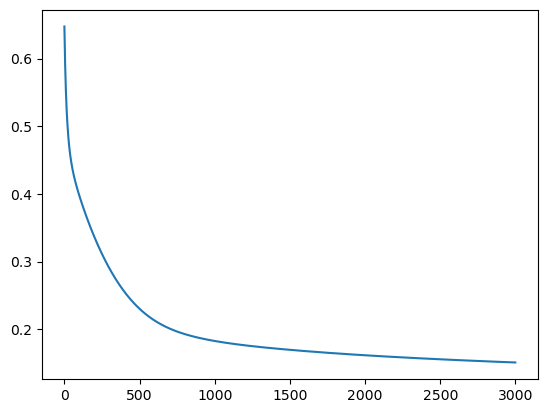

In [18]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)